## Task 3: Predictive Analysis - WIP: DefaultScaler vs MinMaxScaler :WIP
Consider the problem of predicting for each incident (considering the whole dataset for this task) the label which is a **binary variable** that indicates if in the incident there have been at least a killed person or not.


In [563]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import plotly.offline as py
np.random.seed(42)



In [564]:
# Import the datasets
df_incidents_cleaned = pd.read_hdf('../../ds/cleaned/reduced_for_clustering.h5', key = 'df')

# Visualize data table
df_incidents_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131618 entries, 0 to 134578
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       131618 non-null  datetime64[ns]
 1   state                      131618 non-null  object        
 2   city_or_county             131618 non-null  object        
 3   latitude                   131618 non-null  float64       
 4   longitude                  131618 non-null  float64       
 5   congressional_district     131618 non-null  int64         
 6   participant_age_group1     131618 non-null  category      
 7   participant_gender1        131618 non-null  category      
 8   avg_age_participants       131618 non-null  int64         
 9   n_participants_child       131618 non-null  int64         
 10  n_participants_teen        131618 non-null  int64         
 11  n_females                  131618 non-null  int64        

In [565]:
# Import necessary libraries
import pandas as pd

# Assuming df_incidents_cleaned is your DataFrame

# Top three states with the most incidents where ratio_killed is 0
no_victims_states = df_incidents_cleaned[df_incidents_cleaned['ratio_killed'] == 0]['state'].value_counts().head(2)

print("Top two states with most incidents and no victims (ratio_killed = 0):")
print(no_victims_states)

# Top three states with the most incidents where ratio_killed > 0
victims_states = df_incidents_cleaned[df_incidents_cleaned['ratio_killed'] > 0]['state'].value_counts().head(2)

print("\nTop two states with most incidents and highest number of victims (ratio_killed > 0):")
print(victims_states)


Top two states with most incidents and no victims (ratio_killed = 0):
state
Illinois    10456
New York     5490
Name: count, dtype: int64

Top two states with most incidents and highest number of victims (ratio_killed > 0):
state
California    3530
Texas         2971
Name: count, dtype: int64


In [ ]:
df_incidents_cleaned['danger_index'] = df_incidents_cleaned['state'].apply(lambda x: 2 if x == 'California' else 1 if x == 'Texas' else -1 if x == 'Illinois' else -2 if x == 'New York' else 0)

In [566]:

df_incidents_dt = df_incidents_cleaned.copy()

<Axes: title={'center': 'Percentage of incidents with killed people'}, ylabel='count'>

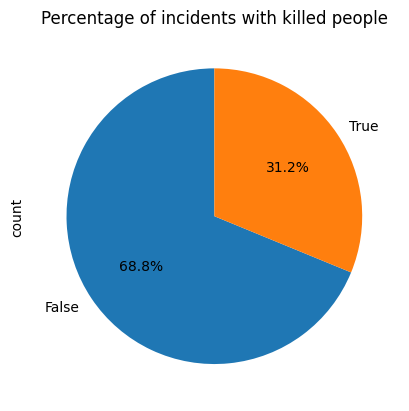

In [567]:
df_incidents_dt['isKilled'] = df_incidents_dt['ratio_killed'] > 0

#todo decide if mantain or drop the plot
df_incidents_dt['isKilled'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, title = 'Percentage of incidents with killed people')


In [568]:
coumns_not_to_drop_dt = [
                        'isKilled', 
                        'n_arrested', 
                        'n_females',
                        'avg_age_participants',
                        'participant_age_group1', 
                        #'density_incident_state', 
                        #'state', 
                        #'n_injured',
                        'danger_index',
                        'male_indicator'
                        'ratio_killed'
                        ]

# broke all if you add n_killed since is higly correlated : 0.94 <-- report consideration

all_columns_dt = df_incidents_dt.columns

columns_to_drop_dt = [x for x in all_columns_dt if x not in coumns_not_to_drop_dt]

df_incidents_dt.drop(columns_to_drop_dt, axis = 1, inplace = True)
df_incidents_dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131618 entries, 0 to 134578
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   participant_age_group1  131618 non-null  category
 1   avg_age_participants    131618 non-null  int64   
 2   n_females               131618 non-null  int64   
 3   n_arrested              131618 non-null  int64   
 4   isKilled                131618 non-null  bool    
dtypes: bool(1), category(1), int64(3)
memory usage: 4.3 MB


In [569]:

#make consideration about why we drop this columns and how they influence the models results
column_to_drop =  [
                   'longitude',
                   'latitude', 
                   'congressional_district',
                   'participant_age_group1',
                   'participant_gender1',
                   'incident_characteristics1',
                   'city_or_county',
                   'date',
                   'n_injured',
                   'party',
                   'candidatevotes',
                   'totalvotes',
                   'n_killed',
                   #'ratio_killed'
                   ]


In [570]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

# Assuming df_incidents_cleaned is your original DataFrame

UMBALANCE_DATA =  False

if not UMBALANCE_DATA:

    # Select 100 samples where isKilled is True
    killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=30000, random_state=42)
    
    killed_samples_small = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=7000, random_state=42)
    # Select 100 samples where isKilled is False
    not_killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=30000, random_state=42)
    
    not_killed_samples_small = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=7000, random_state=42)
else:
    
    killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == True].sample(n=500, random_state=42)
    
    not_killed_samples = df_incidents_dt[df_incidents_dt['isKilled'] == False].sample(n=3000, random_state=42) 


# Concatenate the balanced samples into a new DataFrame
balanced_df = pd.concat([killed_samples, not_killed_samples])
balanced_df_small = pd.concat([killed_samples_small, not_killed_samples_small])
# Shuffle the rows in the new DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df_small = balanced_df_small.sample(frac=1, random_state=42).reset_index(drop=True)
# Display the balanced DataFrame
#print(balanced_df.head())  # You can replace this with your desired way of using the balanced dataset


In [571]:

target = balanced_df['isKilled']
target_small = balanced_df_small['isKilled']
df_dt = balanced_df.drop(['isKilled'], axis = 1)
df_dt_small = balanced_df_small.drop(['isKilled'], axis = 1)
df_dt = pd.get_dummies(df_dt)
df_dt_small = pd.get_dummies(df_dt_small)
df_dt_small.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   avg_age_participants               14000 non-null  int64
 1   n_females                          14000 non-null  int64
 2   n_arrested                         14000 non-null  int64
 3   participant_age_group1_Adult 18+   14000 non-null  bool 
 4   participant_age_group1_Child 0-11  14000 non-null  bool 
 5   participant_age_group1_Teen 12-17  14000 non-null  bool 
dtypes: bool(3), int64(3)
memory usage: 369.3 KB


In [572]:

#X_train, X_test, y_train, y_test = train_test_split(df_dt, target, test_size=test_size, random_state=random_state)
train_set, test_set, train_label, test_label = train_test_split(df_dt, target, stratify = target, test_size=0.30)
train_set_small, test_set_small, train_label_small, test_label_small = train_test_split(df_dt_small, target_small, stratify = target_small, test_size=0.30)


### Scale train test and test set

In [573]:
#Preserve the columns of test and train set
train_set_columns = train_set.columns
test_set_columns = test_set.columns

In [574]:
standard_scaler = StandardScaler()
train_set_minmax = standard_scaler.fit_transform(train_set)
test_set_minmax = standard_scaler.transform(test_set)
train_set_small = standard_scaler.fit_transform(train_set_small)
test_set_small = standard_scaler.transform(test_set_small)

In [575]:
minmax_scaler = MinMaxScaler()
train_set = minmax_scaler.fit_transform(train_set)
test_set = minmax_scaler.transform(test_set)
train_set_small_minmax = minmax_scaler.fit_transform(train_set_small)
test_set_small_minmax = minmax_scaler.transform(test_set_small)


### Todo
- Evaluate Normalization for each model as specific pre-processing (DONE)
- Confusion matrix for each model (Y)
- ROC Curve for each model or general comparison between all models's ROC curve (Y)
- Decision tree grid search (Y)
    - Evaluate split based on GINI, Entropy and Misclassification error (Y)
    - Hunt’s algorithm for semi-optimal DT on large dataset (N)
    - Trees comparison by plot error vs number of nodes of DT in train and test (Y)
    - Evaluate complexity using Minimum Description Length (BOH)
- For NN, evaluate sampling strategies (even simplest one like stratified, over/under) (N)
- Ensemble methods (?)
    - AdaBoost (explained) (boh, se cè tempo)

# Logistic Regression

In [576]:
# import linear regression from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
# add grid search CV
from sklearn.model_selection import GridSearchCV

# With StndardScaler
clf = LogisticRegression(random_state=0, max_iter=700, penalty='l2').fit(train_set, train_label)

clf.predict(test_set)

clf.predict_proba(test_set)

clf.score

# Use standardScaler
# print scores
print('Accuracy score: ', accuracy_score(test_label, clf.predict(test_set)))
print('Precision score: ', precision_score(test_label, clf.predict(test_set)))
print('Recall score: ', recall_score(test_label, clf.predict(test_set)))

Accuracy score:  0.6088888888888889
Precision score:  0.594649410855708
Recall score:  0.6841111111111111


In [577]:
# With MinMaxScaler
clf_minmax = LogisticRegression(random_state=0, max_iter=700, penalty='l2').fit(train_set_minmax, train_label)

clf_minmax.predict(test_set_minmax)

clf_minmax.predict_proba(test_set_minmax)

clf_minmax.score

# Use standardScaler
# print scores
print('Accuracy score: ', accuracy_score(test_label, clf.predict(test_set_minmax)))
print('Precision score: ', precision_score(test_label, clf.predict(test_set_minmax)))
print('Recall score: ', recall_score(test_label, clf.predict(test_set_minmax)))

Accuracy score:  0.5969444444444445
Precision score:  0.606571393672896
Recall score:  0.5517777777777778


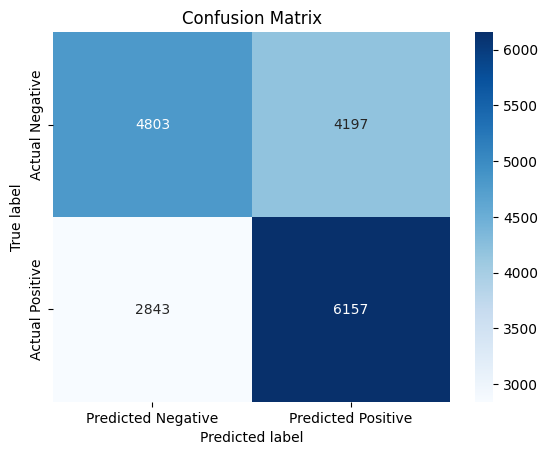

In [578]:
# define confusion matrix 
conf_matrix_regression = confusion_matrix(test_label, clf.predict(test_set))

# heatmap of confusion matrix
sns.heatmap(conf_matrix_regression, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

# labels
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

plt.show()

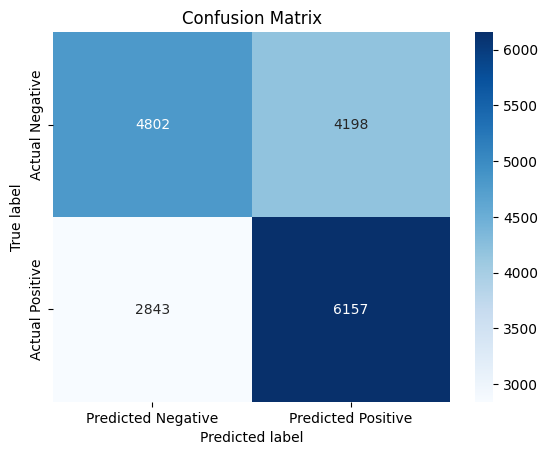

In [579]:
# define confusion matrix 
conf_matrix_regression_minmax = confusion_matrix(test_label, clf_minmax.predict(test_set_minmax))

# heatmap of confusion matrix
sns.heatmap(conf_matrix_regression_minmax, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

# labels
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

plt.show()

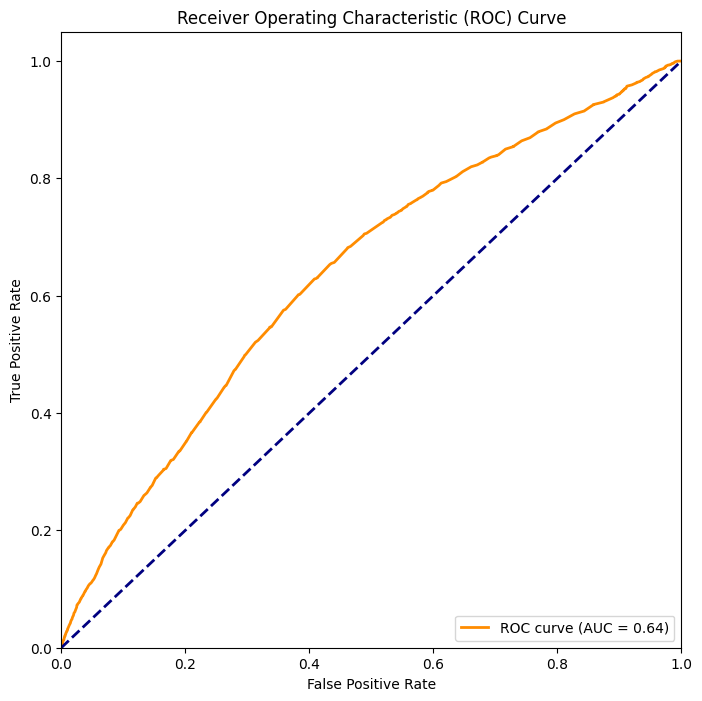

In [580]:
# ROC curve and AUC using positive class probability predicted by the model

# positive class probability predicted by the model
probas_ = clf.predict_proba(test_set)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(test_label, probas_)

# evaluate are under the ROC curve(AUC)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Mostra il plot
plt.show()

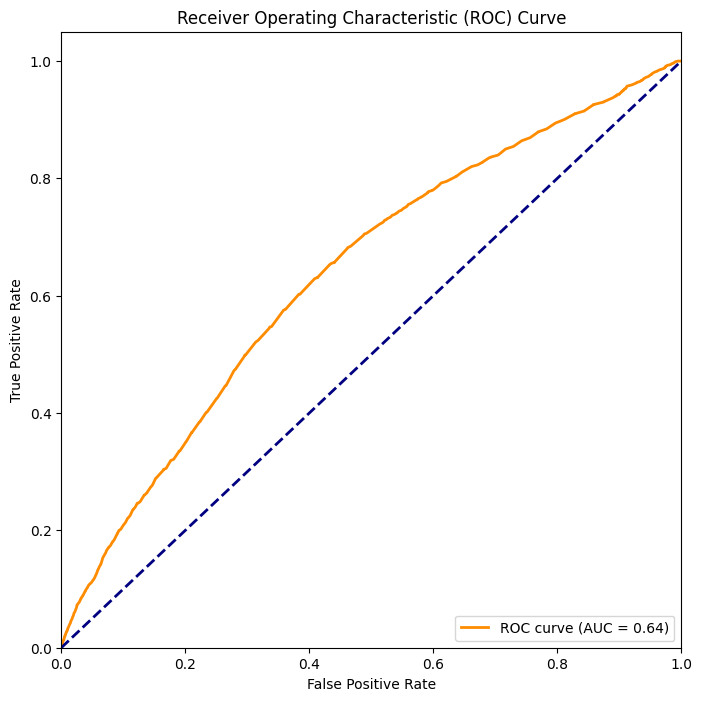

In [581]:
# ROC curve and AUC using positive class probability predicted by the model

# positive class probability predicted by the model
probas_minmax = clf_minmax.predict_proba(test_set_minmax)[:, 1]

# Compute the ROC curve
fpr_mm, tpr_mm, thresholds_mm = roc_curve(test_label, probas_minmax)

# evaluate are under the ROC curve(AUC)
roc_auc_mm = auc(fpr_mm, tpr_mm)

# plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_mm, tpr_mm, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_mm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Mostra il plot
plt.show()

# Decision Tree


In [582]:
#define a decision tree and fit it
# let's do GridSearchCV to find the best parameters
from sklearn.model_selection import GridSearchCV
from sklearn import tree as sktree

parameters_grid_dt = {
        'max_depth': [15, 30, 50],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [4, 10, 20],
        'splitter': ['best', 'random'],
        'criterion': ['gini', 'entropy']
}

# grid search here
grid_search_dt = GridSearchCV(sktree.DecisionTreeClassifier(), parameters_grid_dt, cv=5, scoring='accuracy', verbose=10, n_jobs=-1)

best_model_dt = grid_search_dt.fit(train_set, train_label)

# print best model parameters
print('Best parameters for decision tree: ', best_model_dt.best_estimator_)

# test acc
print('Accuracy score: ', accuracy_score(test_label, best_model_dt.predict(test_set)))

'''
from sklearn import tree
dt = tree.DecisionTreeClassifier(criterion='entropy', 
                                splitter='best', 
                                max_depth=10, 
                                min_samples_split=60, 
                                min_samples_leaf=30)
dt = dt.fit(train_set, train_label)
'''

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5; 1/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=best
[CV 2/5; 1/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=best
[CV 3/5; 1/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=best
[CV 4/5; 1/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=best
[CV 5/5; 1/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=best
[CV 1/5; 2/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=random
[CV 2/5; 2/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=random
[CV 3/5; 2/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=random
[CV 4/5; 2/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_s

[CV 3/5; 7/72] END criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=0.607 total time=   0.0s
[CV 3/5; 8/72] START criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=10, splitter=random
[CV 2/5; 7/72] END criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=0.603 total time=   0.0s
[CV 4/5; 8/72] START criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=10, splitter=random
[CV 5/5; 8/72] START criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=10, splitter=random
[CV 1/5; 9/72] START criterion=gini, max_depth=15, min_samples_leaf=20, min_samples_split=2, splitter=best
[CV 1/5; 7/72] END criterion=gini, max_depth=15, min_samples_leaf=10, min_samples_split=10, splitter=best;, score=0.618 total time=   0.1s
[CV 3/5; 9/72] START criterion=gini, max_depth=15, min_samples_leaf=20, min_samples_split=2, splitter=best
[CV 2/5; 8/72] END criterion=gini, max_

"\nfrom sklearn import tree\ndt = tree.DecisionTreeClassifier(criterion='entropy', \n                                splitter='best', \n                                max_depth=10, \n                                min_samples_split=60, \n                                min_samples_leaf=30)\ndt = dt.fit(train_set, train_label)\n"

In [583]:
parameters_grid_dt = {
        'max_depth': [15, 30, 50],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [4, 10, 20],
        'splitter': ['best', 'random'],
        'criterion': ['gini', 'entropy']
}

# grid search here
grid_search_dt_minmax = GridSearchCV(sktree.DecisionTreeClassifier(), parameters_grid_dt, cv=5, scoring='accuracy', verbose=10, n_jobs=-1)

best_model_dt_minmax = grid_search_dt.fit(train_set_minmax, train_label)

# print best model parameters
print('Best parameters for decision tree: ', best_model_dt_minmax.best_estimator_)

# test acc
print('Accuracy score: ', accuracy_score(test_label, best_model_dt_minmax.predict(test_set_minmax)))



Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5; 1/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=best
[CV 2/5; 1/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=best
[CV 3/5; 1/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=best
[CV 4/5; 1/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=best
[CV 5/5; 1/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=best
[CV 1/5; 2/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=random
[CV 2/5; 2/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=random
[CV 3/5; 2/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, splitter=random
[CV 4/5; 2/72] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_s

In [584]:
#visualize the actual decision tree obtained  -  StandardScaler
#import pydotplus 
#from IPython.display import Image  
#dot_data = tree.export_graphviz(best_model_dt, out_file=None, 
#                         feature_names=list(train_set_columns),  
#                         class_names=['<=50', '>50'],  
#                         filled=True, rounded=True)  
#graph = pydotplus.graph_from_dot_data(dot_data)  
#Image(graph.create_png())

[learning_curve] Training set sizes: [  336  1014  1693  2372  3051  3730  4409  5088  5766  6445  7124  7803
  8482  9161  9840 10518 11197 11876 12555 13234 13913 14592 15270 15949
 16628 17307 17986 18665 19344 20022 20701 21380 22059 22738 23417 24095
 24774 25453 26132 26811 27490 28169 28848 29526 30205 30884 31563 32242
 32921 33600]
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.729, test=0.519) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.627, test=0.582) total time=   0.0s
[CV] START .....................................................................
[CV] END 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of 250 | elapsed:    0.1s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  43 out of 250 | elapsed:    0.2s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  69 out of 250 | elapsed:    0.2s remaining:    0.6s


[CV] END ..................., score=(train=0.618, test=0.602) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.623, test=0.602) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.628, test=0.606) total time=   0.0s
[CV] END ..................., score=(train=0.622, test=0.604) total time=   0.0s
[CV] END ..................., score=(train=0.609, test=0.597) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.614, test=0.599) total time=   0.0s
[CV] START .................

[Parallel(n_jobs=-1)]: Done  95 out of 250 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 121 out of 250 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 147 out of 250 | elapsed:    0.5s remaining:    0.3s


[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.610, test=0.605) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.621, test=0.606) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.621, test=0.607) total time=   0.0s
[CV] END ..................., score=(train=0.618, test=0.608) total time=   0.0s
[CV] START .....................................................................
[CV] START .................

[Parallel(n_jobs=-1)]: Done 173 out of 250 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 199 out of 250 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 225 out of 250 | elapsed:    0.7s remaining:    0.1s


[CV] START .....................................................................
[CV] END ..................., score=(train=0.629, test=0.604) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.627, test=0.601) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.618, test=0.614) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.626, test=0.606) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.615, test=0.602) total time=   0.0s
[CV] END ..................., score=(train=0.626, test=0.612) total time=   0.0s
[CV] START .................

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.7s finished


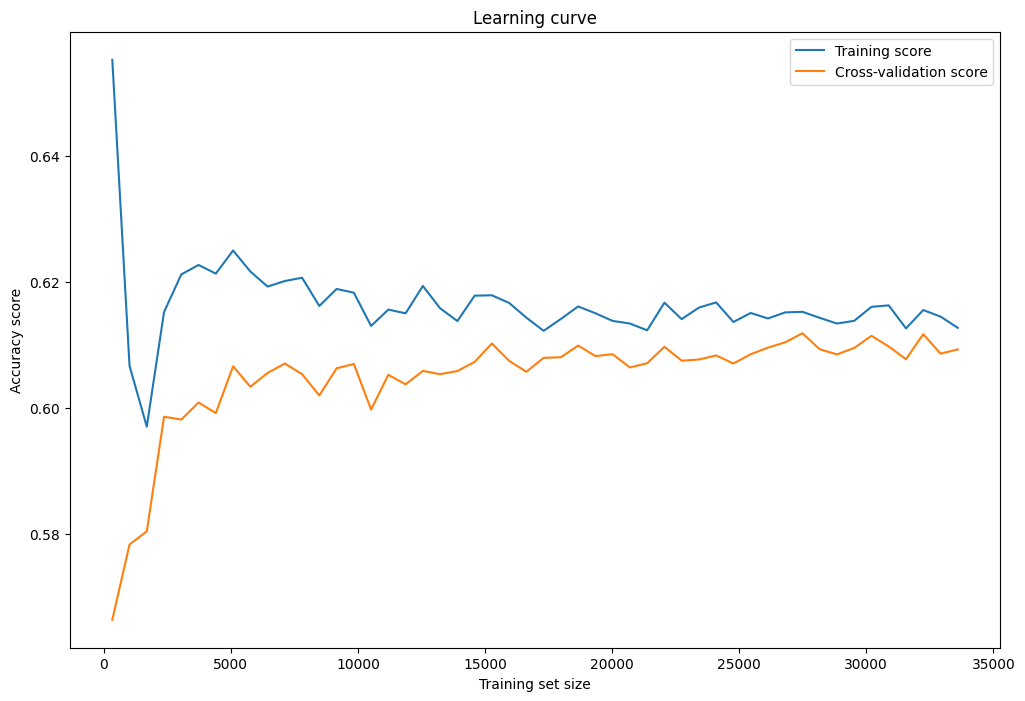

In [585]:
# check for overfitting in decision tree trough plot of the learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model_dt.best_estimator_,
                                                         train_set,
                                                         train_label,
                                                         cv=5,
                                                         scoring='accuracy',
                                                         n_jobs=-1,
                                                         train_sizes=np.linspace(0.01, 1.0, 50),
                                                         verbose=10)

# plot learning curve
plt.figure(figsize=(12,8))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Learning curve')
plt.xlabel('Training set size')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()

[learning_curve] Training set sizes: [  336  1014  1693  2372  3051  3730  4409  5088  5766  6445  7124  7803
  8482  9161  9840 10518 11197 11876 12555 13234 13913 14592 15270 15949
 16628 17307 17986 18665 19344 20022 20701 21380 22059 22738 23417 24095
 24774 25453 26132 26811 27490 28169 28848 29526 30205 30884 31563 32242
 32921 33600]
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.617, test=0.603) total time=   0.0s
[CV] END ..................., score=(train=0.729, test=0.519) total time=   0.0s
[CV] START .....................................................................
[CV] START .....................................................................
[CV] END 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of 250 | elapsed:    0.1s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  43 out of 250 | elapsed:    0.2s remaining:    0.9s


[CV] START .....................................................................
[CV] END ..................., score=(train=0.616, test=0.620) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.632, test=0.593) total time=   0.0s
[CV] END ..................., score=(train=0.617, test=0.622) total time=   0.0s
[CV] END ..................., score=(train=0.624, test=0.603) total time=   0.0s
[CV] END ..................., score=(train=0.628, test=0.599) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.614, test=0.622) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.613, test=0.620) total time=   0.0s
[CV] START .....................................................................
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  69 out of 250 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  95 out of 250 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done 121 out of 250 | elapsed:    0.4s remaining:    0.4s



[CV] START .....................................................................
[CV] START .....................................................................
[CV] END ..................., score=(train=0.619, test=0.610) total time=   0.0s[CV] START .....................................................................

[CV] END ..................., score=(train=0.620, test=0.606) total time=   0.0s
[CV] END ..................., score=(train=0.620, test=0.608) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.617, test=0.606) total time=   0.0s
[CV] END ..................., score=(train=0.608, test=0.603) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.622, test=0.606) total time=   0.0s
[CV] START .....................................................................[CV] END ...................

[Parallel(n_jobs=-1)]: Done 147 out of 250 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 173 out of 250 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 199 out of 250 | elapsed:    0.6s remaining:    0.2s


[CV] END ..................., score=(train=0.612, test=0.612) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.615, test=0.612) total time=   0.0s
[CV] END ..................., score=(train=0.611, test=0.607) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.613, test=0.581) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.606, test=0.592) total time=   0.0s
[CV] END ..................., score=(train=0.620, test=0.600) total time=   0.0s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.608, test=0.604) total time=   0.0s
[CV] START .....................................................................
[CV] START .................

[Parallel(n_jobs=-1)]: Done 225 out of 250 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.8s finished


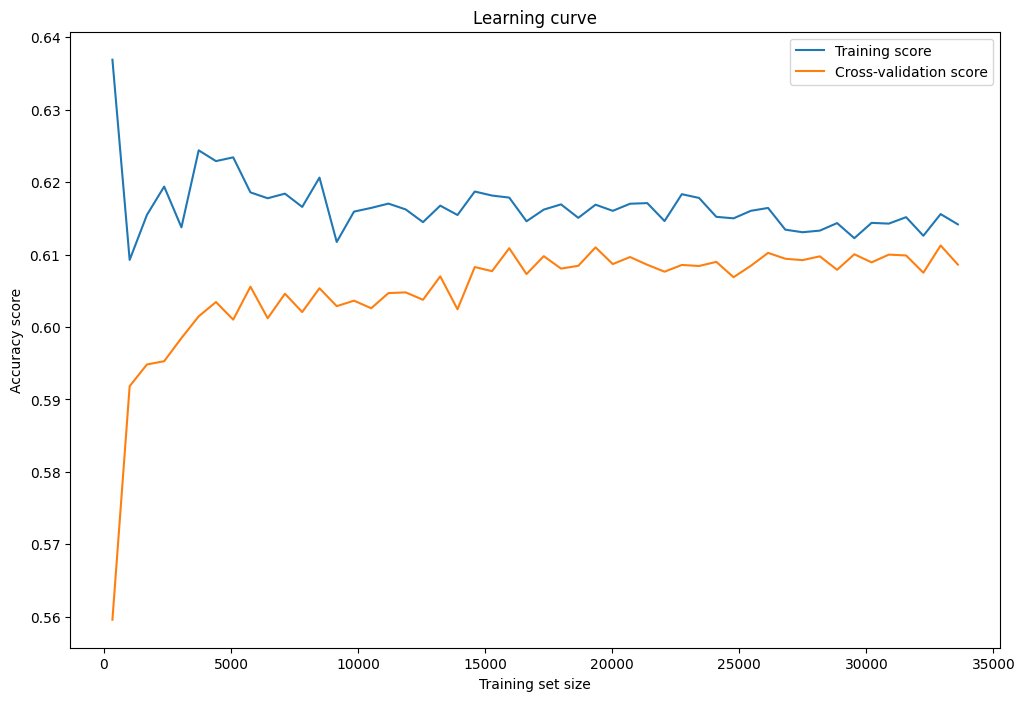

In [586]:
# check for overfitting in decision tree trough plot of the learning curve
from sklearn.model_selection import learning_curve

train_sizes_minmax, train_scores_minmax, test_scores_minmax = learning_curve(best_model_dt_minmax.best_estimator_,
                                                         train_set_minmax,
                                                         train_label,
                                                         cv=5,
                                                         scoring='accuracy',
                                                         n_jobs=-1,
                                                         train_sizes=np.linspace(0.01, 1.0, 50),
                                                         verbose=10)

# plot learning curve
plt.figure(figsize=(12,8))
plt.plot(train_sizes, np.mean(train_scores_minmax, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores_minmax, axis=1), label='Cross-validation score')
plt.title('Learning curve')
plt.xlabel('Training set size')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()

In [587]:
#predict using the decision tree
#the predict function returns the actual predicted labels: we need them for the evaluation phase

#With StandardScaler
train_pred_dt = best_model_dt.predict(train_set)
test_pred_dt = best_model_dt.predict(test_set)

#With MinMaxScaler
train_pred_dt_minmax = best_model_dt_minmax.predict(train_set_minmax)
test_pred_dt_minmax = best_model_dt_minmax.predict(test_set_minmax)

In [588]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
#With StandardScaler
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt))

Accuracy train set  0.5270952380952381
Accuracy test set  0.5290555555555555
Precision train set  0.5450162467624204
Recall train set  0.5270952380952381
F1 score train set  0.4748273067086366
Support train set  (array([0.51661314, 0.57341935]), array([0.84257143, 0.21161905]), array([0.64050679, 0.30914783]), array([21000, 21000]))


In [589]:
#metrics computed on the test set - StandardScaler
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))

In [590]:
report_scores(test_label, test_pred_dt)


              precision    recall  f1-score   support

           0       0.52      0.84      0.64      9000
           1       0.58      0.22      0.32      9000

    accuracy                           0.53     18000
   macro avg       0.55      0.53      0.48     18000
weighted avg       0.55      0.53      0.48     18000



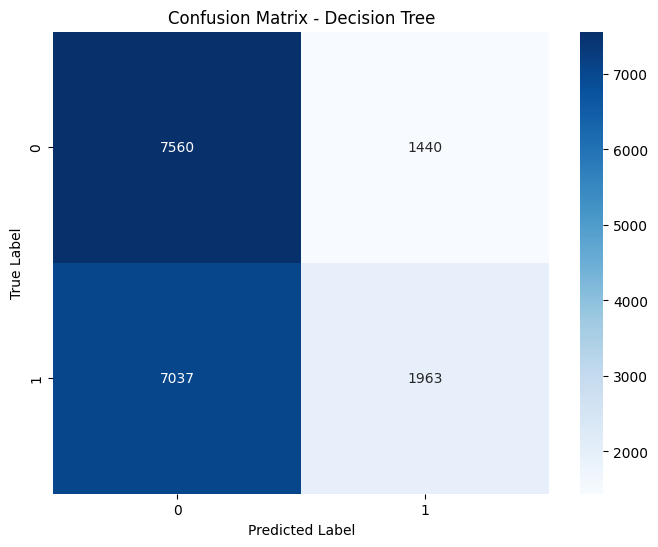

In [591]:

# Calcola la matrice di confusione
conf_matrix_dt = confusion_matrix(test_label, test_pred_dt)

# Crea il heatmap con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

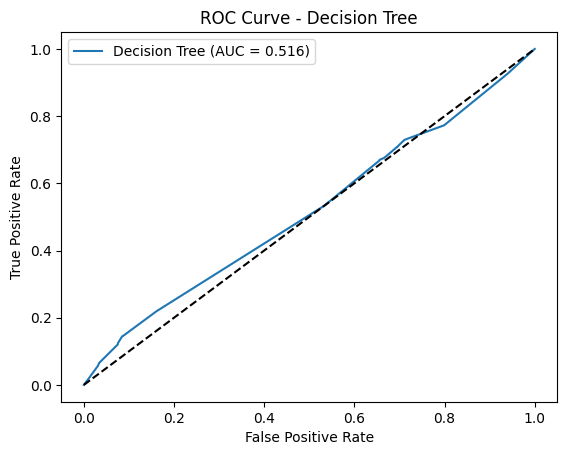

In [592]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calcola le probabilità predette per la classe positiva (classe 1)
test_pred_proba_dt = best_model_dt.predict_proba(test_set)[:, 1]

# Calcola la curva ROC
fpr_dt, tpr_dt, thresholds_dt = roc_curve(test_label, test_pred_proba_dt)

# Calcola l'area sotto la curva ROC (AUC)
roc_auc_dt = roc_auc_score(test_label, test_pred_proba_dt)

# Visualizza la curva ROC
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.show()

In [593]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
#With MinMaxScaler
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt_minmax))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt_minmax))
print('Precision train set ', metrics.precision_score(train_label, train_pred_dt_minmax, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_dt_minmax, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_dt_minmax, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_dt_minmax))



Accuracy train set  0.6085238095238096
Accuracy test set  0.6127222222222222
Precision train set  0.6141800663090375
Recall train set  0.6085238095238096
F1 score train set  0.6036147726307073
Support train set  (array([0.63959329, 0.58876685]), array([0.4972381 , 0.71980952]), array([0.55950276, 0.64772679]), array([21000, 21000]))


In [594]:
#metrics computed on the test set - MinMaxScaler
from sklearn.metrics import classification_report
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))
report_scores(test_label, test_pred_dt_minmax)


              precision    recall  f1-score   support

           0       0.64      0.51      0.57      9000
           1       0.59      0.72      0.65      9000

    accuracy                           0.61     18000
   macro avg       0.62      0.61      0.61     18000
weighted avg       0.62      0.61      0.61     18000



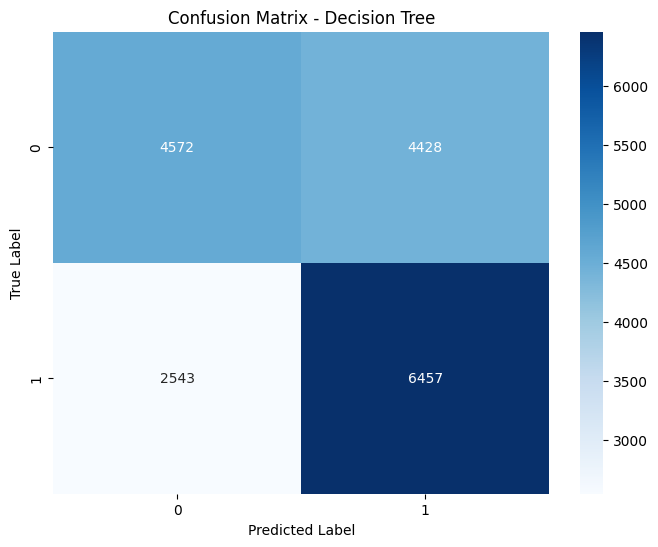

In [595]:

# Calcola la matrice di confusione
conf_matrix_dt_mm = confusion_matrix(test_label, test_pred_dt_minmax)

# Crea il heatmap con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_dt_mm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

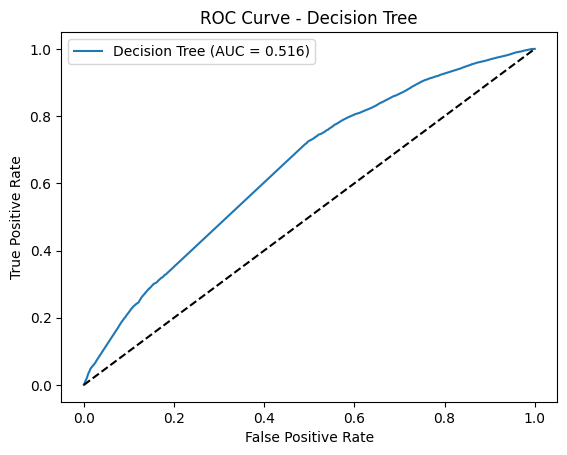

In [596]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calcola le probabilità predette per la classe positiva (classe 1)
test_pred_proba_dt_mm = best_model_dt_minmax.predict_proba(test_set_minmax)[:, 1]

# Calcola la curva ROC
fpr_dt_mm, tpr_dt_mm, thresholds_dt_mm = roc_curve(test_label, test_pred_proba_dt_mm)

# Calcola l'area sotto la curva ROC (AUC)
roc_auc_dt_mm = roc_auc_score(test_label, test_pred_proba_dt)

# Visualizza la curva ROC
plt.plot(fpr_dt_mm, tpr_dt_mm, label=f'Decision Tree (AUC = {roc_auc_dt_mm:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend()
plt.show()

# Neural Network: MLP

In [597]:
import tensorflow as tf
import numpy as np
#With StandardScaler
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, len(train_set_columns))),
  tf.keras.layers.Dense(32, activation='sigmoid'),  
  tf.keras.layers.Dense(1, activation='sigmoid')
])


#Use standardScaler
model.compile(optimizer='adamax',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [598]:
#With StandardScaler
y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
x_train = np.reshape(train_set, (len(train_set), 1, len(train_set_columns)))
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)
history = model.fit(x_train, y_train,
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Epoch 1/30
132/132 [==============================] - 1s 2ms/step - loss: 0.2645 - accuracy: 0.5033 - val_loss: 0.2489 - val_accuracy: 0.5473
Epoch 2/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2483 - accuracy: 0.5537 - val_loss: 0.2479 - val_accuracy: 0.5657
Epoch 3/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2474 - accuracy: 0.5734 - val_loss: 0.2470 - val_accuracy: 0.5838
Epoch 4/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2465 - accuracy: 0.5844 - val_loss: 0.2462 - val_accuracy: 0.5854
Epoch 5/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2457 - accuracy: 0.5891 - val_loss: 0.2455 - val_accuracy: 0.5920
Epoch 6/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2450 - accuracy: 0.5921 - val_loss: 0.2448 - val_accuracy: 0.5956
Epoch 7/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2444 - accuracy: 0.5934 - val_loss: 0.2443 - val_accuracy: 0.5926
Epoch 

In [599]:
model_minmax = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, len(train_set_columns))),
  tf.keras.layers.Dense(32, activation='sigmoid'),  
  tf.keras.layers.Dense(1, activation='sigmoid')
])


#Use standardScaler
model_minmax.compile(optimizer='adamax',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [600]:
#With MinMaxScaler
y_train_minmax = np.asarray(train_label).astype('float32').reshape((-1,1))
x_train_minmax = np.reshape(train_set_minmax, (len(train_set_minmax), 1, len(train_set_columns)))
x_train_minmax = x_train_minmax.astype(np.float32)
y_train_minmax = y_train_minmax.astype(np.float32)
history = model_minmax.fit(x_train_minmax, y_train_minmax,
                    epochs=30,
                    batch_size=256,
                    validation_split=0.2)

Epoch 1/30
132/132 [==============================] - 1s 2ms/step - loss: 0.2968 - accuracy: 0.5005 - val_loss: 0.2538 - val_accuracy: 0.4995
Epoch 2/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2483 - accuracy: 0.5749 - val_loss: 0.2447 - val_accuracy: 0.5881
Epoch 3/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2427 - accuracy: 0.5947 - val_loss: 0.2411 - val_accuracy: 0.5992
Epoch 4/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2402 - accuracy: 0.5973 - val_loss: 0.2395 - val_accuracy: 0.5977
Epoch 5/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2390 - accuracy: 0.5998 - val_loss: 0.2387 - val_accuracy: 0.5948
Epoch 6/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2384 - accuracy: 0.5982 - val_loss: 0.2382 - val_accuracy: 0.5989
Epoch 7/30
132/132 [==============================] - 0s 2ms/step - loss: 0.2381 - accuracy: 0.5995 - val_loss: 0.2380 - val_accuracy: 0.5951
Epoch 

In [601]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 6)                 0         
                                                                 
 dense_30 (Dense)            (None, 32)                224       
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 257 (1.00 KB)
Trainable params: 257 (1.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [602]:
model_minmax.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 6)                 0         
                                                                 
 dense_32 (Dense)            (None, 32)                224       
                                                                 
 dense_33 (Dense)            (None, 1)                 33        
                                                                 
Total params: 257 (1.00 KB)
Trainable params: 257 (1.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


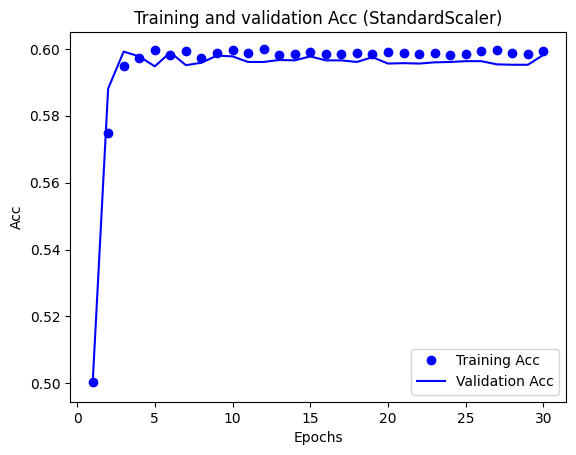

In [603]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc (StandardScaler)')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

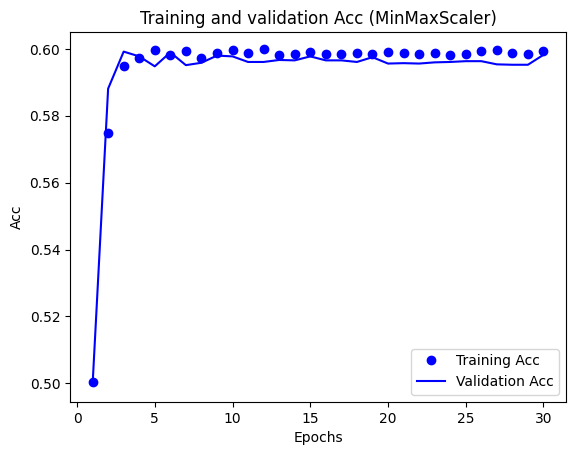

In [604]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc (MinMaxScaler)')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [605]:
# Convert the test set to float32 if needed - StandardScaler
x_test = np.reshape(test_set, (len(test_set), 1, len(test_set_columns)))
x_test = x_test.astype(np.float32)

# Then proceed with prediction
test_pred_nn = (model.predict(x_test) > 0.6).astype("int32")


563/563 [==============================] - 1s 1ms/step


In [606]:
# Convert the test set to float32 if needed - mINMAXScaler
x_test_minmax = np.reshape(test_set_minmax, (len(test_set_minmax), 1, len(test_set_columns)))
x_test_minmax = x_test_minmax.astype(np.float32)

# Then proceed with prediction
test_pred_nn_minmax = (model_minmax.predict(x_test_minmax) > 0.6).astype("int32")


563/563 [==============================] - 1s 928us/step


In [607]:
report_scores(test_label, test_pred_nn)

              precision    recall  f1-score   support

           0       0.53      0.92      0.67      9000
           1       0.69      0.17      0.27      9000

    accuracy                           0.55     18000
   macro avg       0.61      0.55      0.47     18000
weighted avg       0.61      0.55      0.47     18000



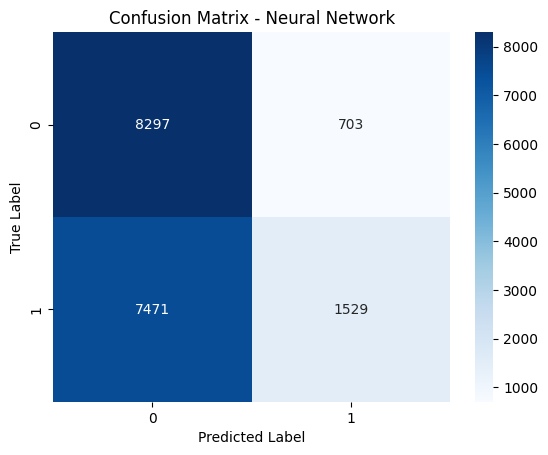

In [608]:
# Convert test labels to float32
y_test = np.asarray(test_label).astype('float32').reshape((-1, 1))

# evaluate confusion matrix
conf_matrix_nn = confusion_matrix(y_test, test_pred_nn)

sns.heatmap(conf_matrix_nn, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Neural Network')
plt.show()

563/563 [==============================] - 0s 846us/step


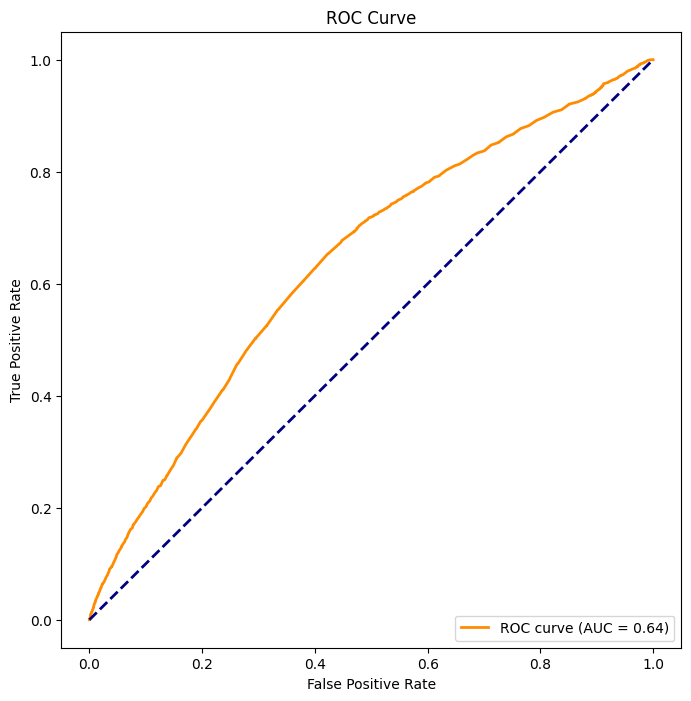

In [609]:
# Calcola le probabilità predette dal modello
pred_prob = model.predict(x_test)

# Calcola la ROC curve
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)

# Calcola l'area sotto la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Visualizza la ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [610]:
report_scores(test_label, test_pred_nn_minmax)

              precision    recall  f1-score   support

           0       0.54      0.89      0.67      9000
           1       0.68      0.23      0.34      9000

    accuracy                           0.56     18000
   macro avg       0.61      0.56      0.51     18000
weighted avg       0.61      0.56      0.51     18000



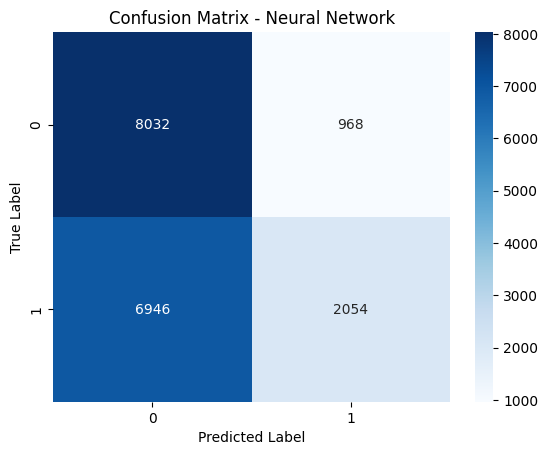

In [611]:
# Convert test labels to float32
y_test_mm = np.asarray(test_label).astype('float32').reshape((-1, 1))

# evaluate confusion matrix
conf_matrix_nn_mm = confusion_matrix(y_test, test_pred_nn_minmax)

sns.heatmap(conf_matrix_nn_mm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Neural Network')
plt.show()

563/563 [==============================] - 1s 928us/step


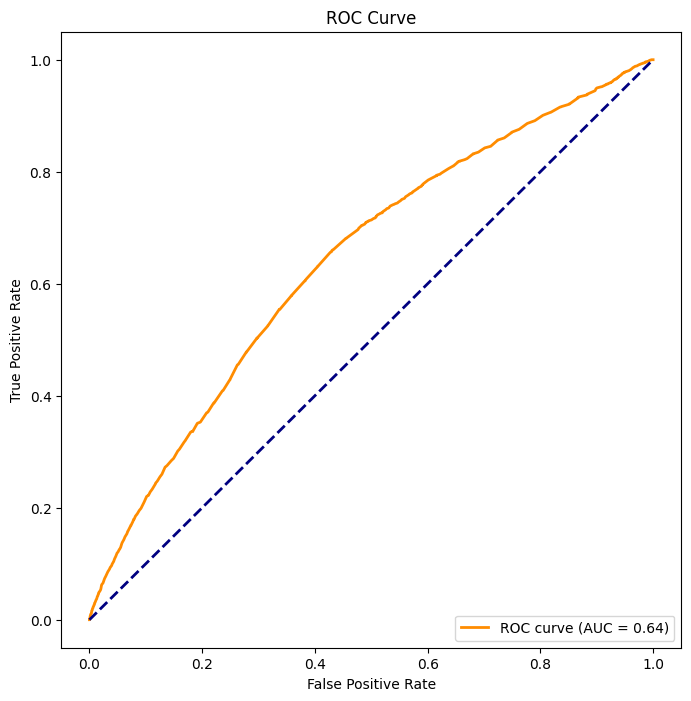

In [612]:
# Calcola le probabilità predette dal modello
pred_prob_mm = model_minmax.predict(x_test_minmax)

# Calcola la ROC curve
fpr, tpr, thresholds = roc_curve(y_test_mm, pred_prob_mm)

# Calcola l'area sotto la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Visualizza la ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Trying now models that can't scale really well with data size

## K-NN Classifier


100%|██████████| 24/24 [00:15<00:00,  1.52it/s]


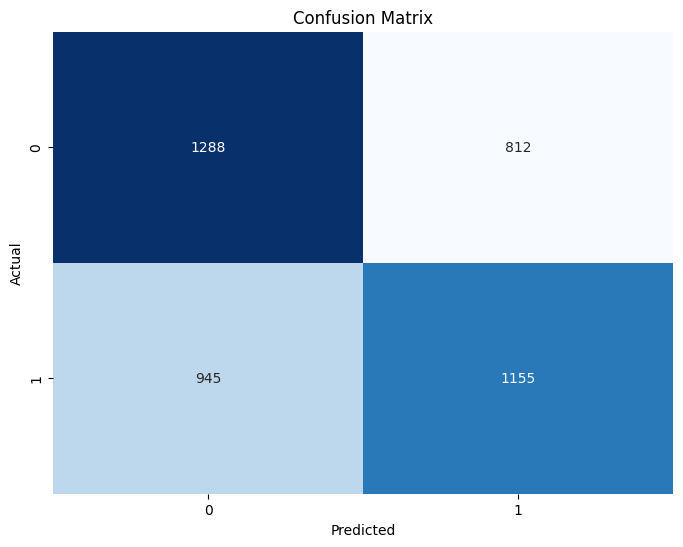

In [613]:
from sklearn.neighbors import KNeighborsClassifier
# use tqdm
import tqdm

#With StandardScaler

k_list = [x for x in range(1, 25)]

knn_list = []
for k in tqdm.tqdm(k_list):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_set_small, train_label_small)
    knn_list.append(knn.score(test_set_small, test_label_small))
    
    # predictions
    prediction_train = knn.predict(train_set_small)
    prediction_test = knn.predict(test_set_small)
    
    #accuracy
    accuracy_train = metrics.accuracy_score(train_label_small, prediction_train)
    accuracy_test = metrics.accuracy_score(test_label_small, prediction_test)

# k with best acccuracy
best_k = k_list[np.argmax(knn_list)]

# re-train with beast k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(train_set_small, train_label_small)

# predict
predictions = best_knn.predict(test_set_small)

# confusion matrix
cm = confusion_matrix(test_label_small, predictions)

# Plot confusion matrix con heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
    

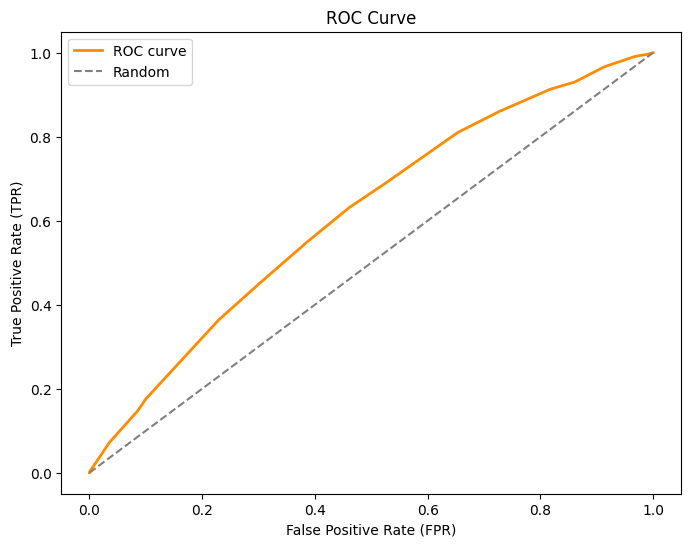

AUC: 0.615


In [614]:
# Calcola le probabilità predette per le classi positive
y_scores = best_knn.predict_proba(test_set_small)[:, 1]

# Calcola la curva ROC
fpr, tpr, thresholds = roc_curve(test_label_small, y_scores)

# Plotta la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calcola l'area sotto la curva ROC (AUC)
roc_auc = roc_auc_score(test_label_small, y_scores)
print(f'AUC: {roc_auc:.3f}')


100%|██████████| 24/24 [00:13<00:00,  1.82it/s]


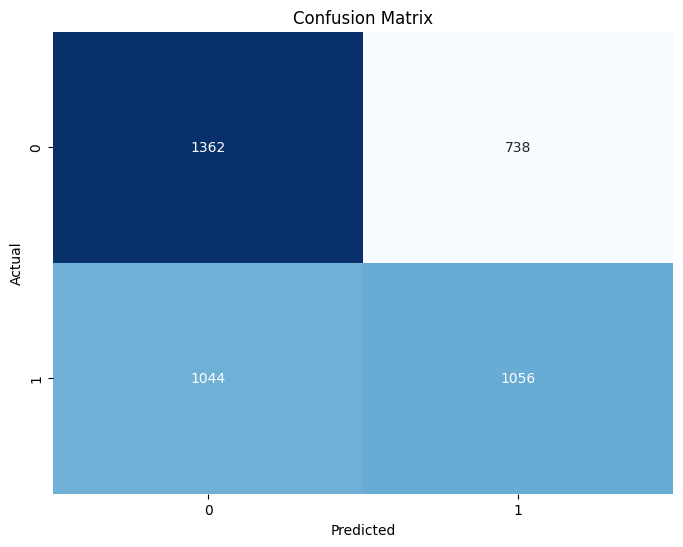

In [615]:
#With MinMaxScaler
k_list = [x for x in range(1, 25)]

knn_list_minmax = []
for k in tqdm.tqdm(k_list):
    knn_minmax = KNeighborsClassifier(n_neighbors=k)
    knn_minmax.fit(train_set_small_minmax, train_label_small)
    knn_list_minmax.append(knn_minmax.score(test_set_small_minmax, test_label_small))
    
    # predictions
    prediction_train_minmax = knn_minmax.predict(train_set_small_minmax)
    prediction_test_minmax = knn_minmax.predict(test_set_small_minmax)
    
    #accuracy
    accuracy_train_minmax = metrics.accuracy_score(train_label_small, prediction_train_minmax)
    accuracy_test_minmax = metrics.accuracy_score(test_label_small, prediction_test_minmax)


# k with best acccuracy
best_k_mm = knn_list_minmax[np.argmax(knn_list_minmax)]

# re-train with beast k
best_knn_mm = KNeighborsClassifier(n_neighbors=best_k)
best_knn_mm.fit(train_set_small_minmax, train_label_small)

# predict
predictions_mm = best_knn_mm.predict(test_set_small_minmax)

# confusion matrix
cm_mm = confusion_matrix(test_label_small, predictions_mm)

# Plot confusion matrix con heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_mm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

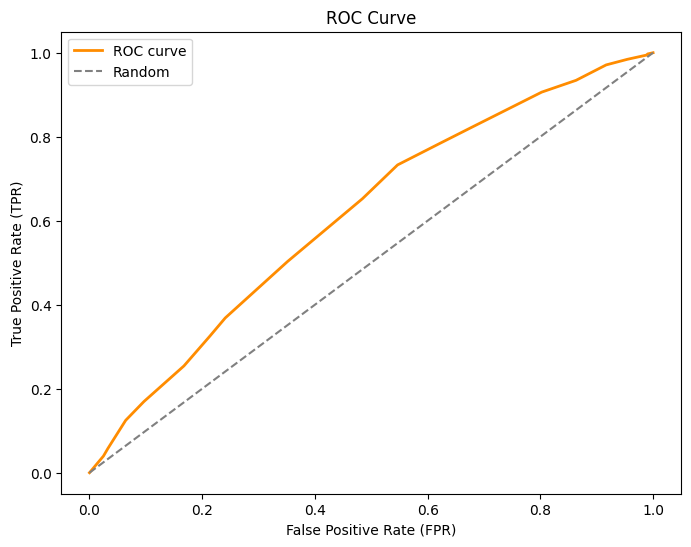

AUC: 0.613


In [616]:
# Calcola le probabilità predette per le classi positive
y_scores_mm = best_knn_mm.predict_proba(test_set_small_minmax)[:, 1]

# Calcola la curva ROC
fpr_mm, tpr_mm, thresholds_mm = roc_curve(test_label_small, y_scores_mm)

# Plotta la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_mm, tpr_mm, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Calcola l'area sotto la curva ROC (AUC)
roc_auc_mm = roc_auc_score(test_label_small, y_scores_mm)
print(f'AUC: {roc_auc_mm:.3f}')


In [617]:
# print accuracy
print("Accuracy train (StandardScaler):", accuracy_train)
print("Accuracy test (StandardScaler):", accuracy_test)

Accuracy train (StandardScaler): 0.6087755102040816
Accuracy test (StandardScaler): 0.5816666666666667


In [618]:
# print accuracy
print("Accuracy train (MinMax):", accuracy_train_minmax)
print("Accuracy test (MinMax):", accuracy_test_minmax)

Accuracy train (MinMax): 0.6083673469387755
Accuracy test (MinMax): 0.5757142857142857


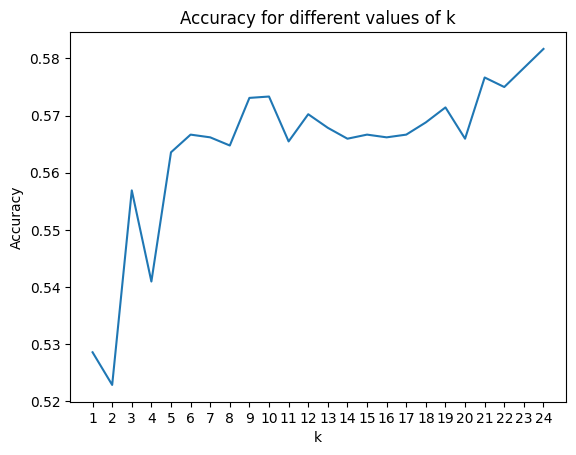

In [619]:
# plot results knn on x axis and accuracy on y axis - standardScaler
plt.plot(k_list, knn_list)
plt.xlabel('k')
plt.ylabel('Accuracy')
#track each k only
plt.xticks(k_list)
plt.title('Accuracy for different values of k')
# todo plot scores
plt.show()  

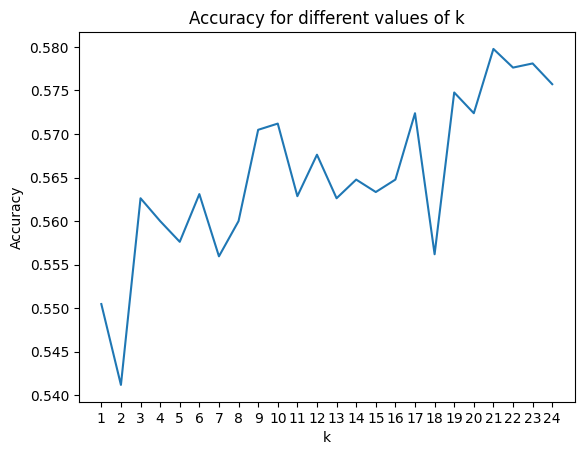

In [620]:
# plot results knn on x axis and accuracy on y axis - MinMaxScaler
plt.plot(k_list, knn_list_minmax)
plt.xlabel('k')
plt.ylabel('Accuracy')
#track each k only
plt.xticks(k_list)
plt.title('Accuracy for different values of k')
# todo plot scores
plt.show()  

## Support Vector Machine

In [621]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm

#train_set, test_set, train_label, test_label = train_test_split(df_dt, target, stratify = target, test_size=0.30)
# X_train, X_test, y_train, y_test = train_test_split(df_dt, target, test_size=test_size, random_state=random_state)

#x_train_reshaped = train_set.reshape(train_set.shape[0], -1)


svm_classifier = SVC(kernel='linear')
svm_classifier_rbf = SVC(kernel='rbf', C=1, gamma=0.1)

svm_classifier.fit(train_set_small, train_label_small)
svm_classifier_rbf.fit(train_set_small, train_label_small)

SVC(C=1, gamma=0.1)

In [622]:
#SVM with MinMaxScaler
svm_classifier_minmax = SVC(kernel='linear')
svm_classifier_rbf_minmax = SVC(kernel='rbf', C=1, gamma=0.1)

svm_classifier_minmax.fit(train_set_small_minmax, train_label_small)
svm_classifier_rbf_minmax.fit(train_set_small_minmax, train_label_small)

SVC(C=1, gamma=0.1)

In [623]:
def print_svm_scores(svm_classifier):
    print("Accuracy on training set: {:.3f}".format(svm_classifier.score(train_set_small, train_label_small)))
    print("Accuracy on test set: {:.3f}".format(svm_classifier.score(test_set_small, test_label_small)))
    
    # Make predictions
    y_pred = svm_classifier.predict(test_set_small)

    # Evaluate the model
    accuracy = accuracy_score(test_label_small, y_pred)
    report = classification_report(test_label_small, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)

In [624]:
print_svm_scores(svm_classifier)

Accuracy on training set: 0.587
Accuracy on test set: 0.587
Accuracy: 0.59
Classification Report:
              precision    recall  f1-score   support

       False       0.63      0.42      0.50      2100
        True       0.57      0.76      0.65      2100

    accuracy                           0.59      4200
   macro avg       0.60      0.59      0.58      4200
weighted avg       0.60      0.59      0.58      4200



In [625]:
print_svm_scores(svm_classifier_rbf)

Accuracy on training set: 0.608
Accuracy on test set: 0.610
Accuracy: 0.61
Classification Report:
              precision    recall  f1-score   support

       False       0.64      0.51      0.57      2100
        True       0.59      0.71      0.65      2100

    accuracy                           0.61      4200
   macro avg       0.61      0.61      0.61      4200
weighted avg       0.61      0.61      0.61      4200



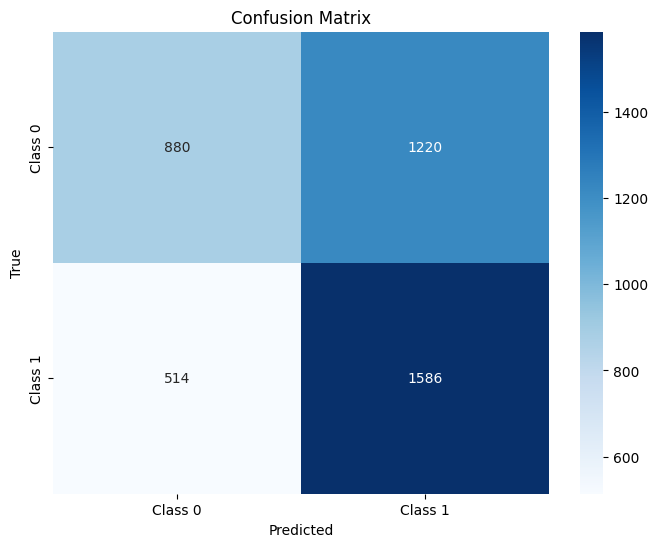

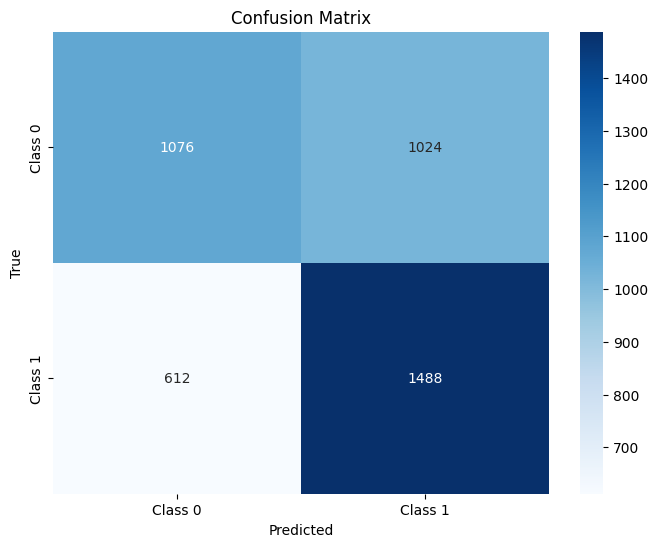

In [626]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

 
y_pred_linear = svm_classifier.predict(test_set_small)
plot_confusion_matrix(test_label_small, y_pred_linear, class_names=['Class 0', 'Class 1'])

y_pred_rbf = svm_classifier_rbf.predict(test_set_small)
plot_confusion_matrix(test_label_small, y_pred_rbf, class_names=['Class 0', 'Class 1'])

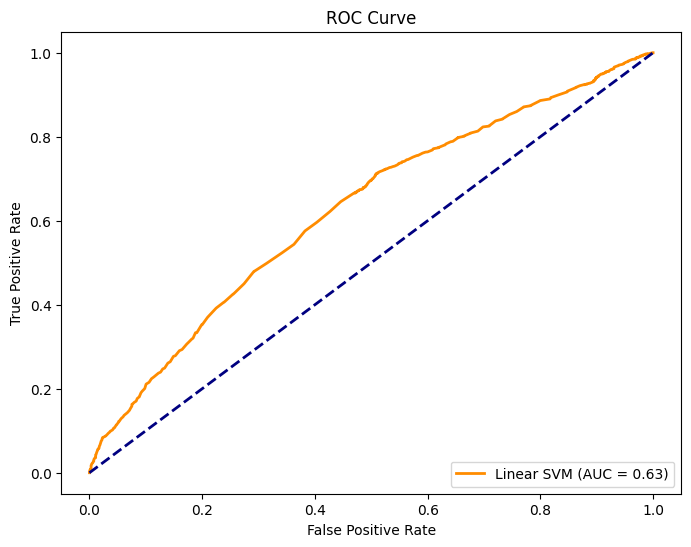

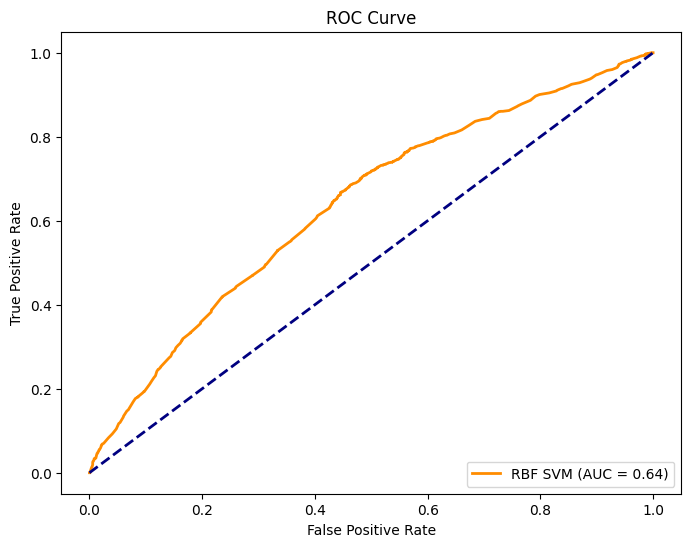

In [627]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, label):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Per il classificatore lineare
y_scores_linear = svm_classifier.decision_function(test_set_small)
plot_roc_curve(test_label_small, y_scores_linear, label='Linear SVM')

# Per il classificatore RBF
y_scores_rbf = svm_classifier_rbf.decision_function(test_set_small)
plot_roc_curve(test_label_small, y_scores_rbf, label='RBF SVM')

In [628]:
print_svm_scores(svm_classifier_minmax)

Accuracy on training set: 0.594
Accuracy on test set: 0.598
Accuracy: 0.60
Classification Report:
              precision    recall  f1-score   support

       False       0.61      0.53      0.57      2100
        True       0.59      0.67      0.62      2100

    accuracy                           0.60      4200
   macro avg       0.60      0.60      0.60      4200
weighted avg       0.60      0.60      0.60      4200



In [629]:
print_svm_scores(svm_classifier_rbf_minmax)

Accuracy on training set: 0.576
Accuracy on test set: 0.571
Accuracy: 0.57
Classification Report:
              precision    recall  f1-score   support

       False       0.61      0.38      0.47      2100
        True       0.55      0.76      0.64      2100

    accuracy                           0.57      4200
   macro avg       0.58      0.57      0.55      4200
weighted avg       0.58      0.57      0.55      4200



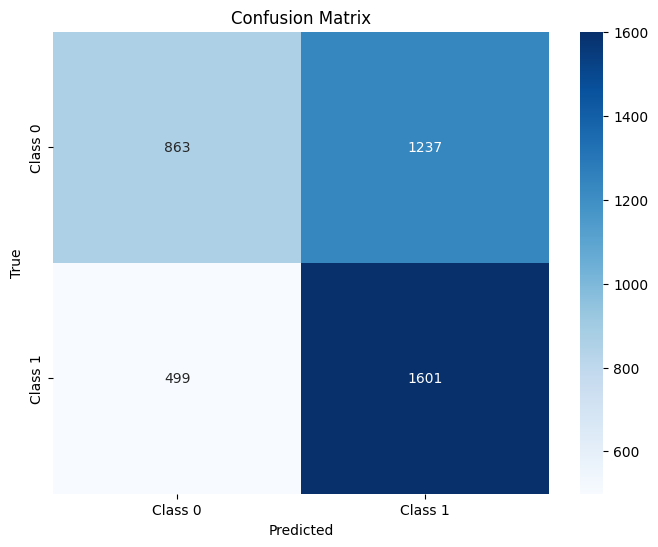

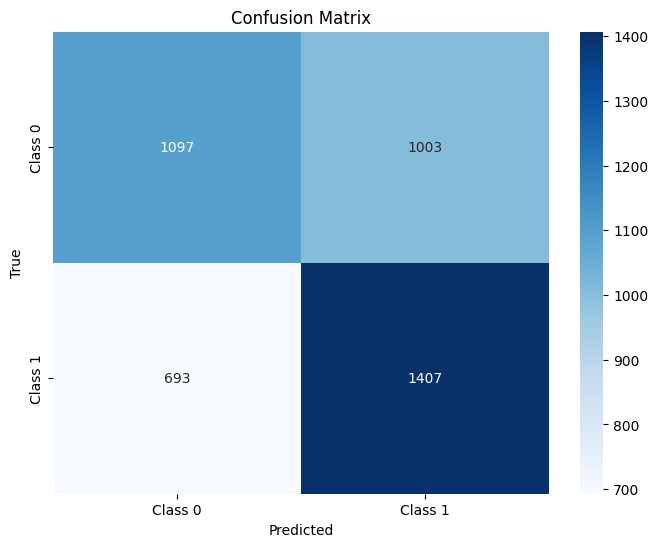

In [630]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

 
y_pred_linear_mm = svm_classifier_minmax.predict(test_set_small_minmax)
plot_confusion_matrix(test_label_small, y_pred_linear_mm, class_names=['Class 0', 'Class 1'])

y_pred_rbf_mm = svm_classifier_rbf_minmax.predict(test_set_small_minmax)
plot_confusion_matrix(test_label_small, y_pred_rbf_mm, class_names=['Class 0', 'Class 1'])

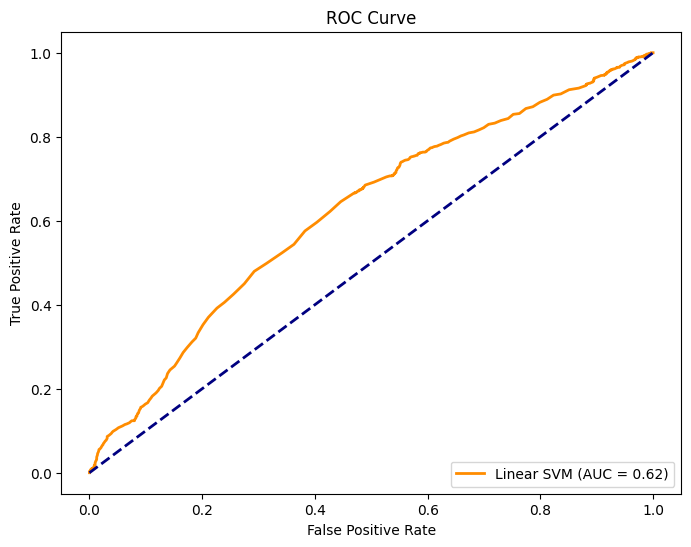

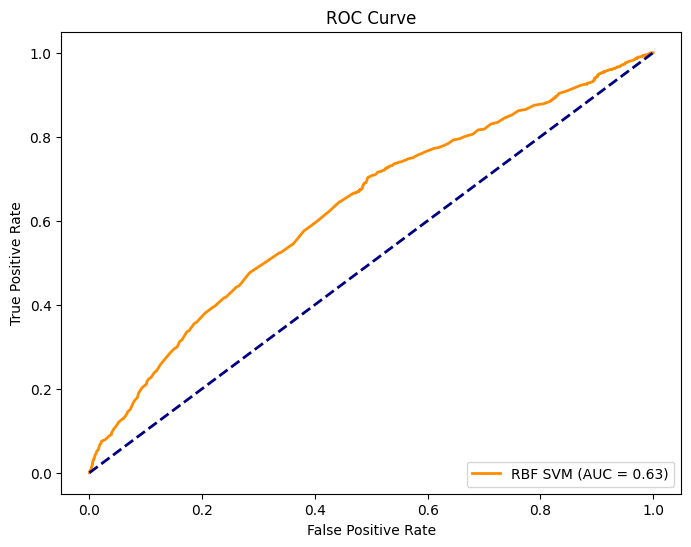

In [631]:

# Per il classificatore lineare
y_scores_linear_mm = svm_classifier_minmax.decision_function(test_set_small_minmax)
plot_roc_curve(test_label_small, y_scores_linear_mm, label='Linear SVM')

# Per il classificatore RBF
y_scores_rbf_mm = svm_classifier_rbf_minmax.decision_function(test_set_small_minmax)
plot_roc_curve(test_label_small, y_scores_rbf_mm, label='RBF SVM')

# BE CAREFUL WE CAN MOVE THIS UP BECAUSE THIS DO NOT SUFFER OF PROBLEM WITH DATA SIZE

## Radom Forest

In [632]:
# try random forest without grid search

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


clf = RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10, criterion='entropy', n_estimators = 100)
clf_gini = RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10, criterion='gini', n_estimators = 100)

clf_gini.fit(train_set, train_label)
clf.fit(train_set, train_label)


RandomForestClassifier(criterion='entropy', max_depth=10, max_features=10,
                       min_samples_leaf=10)

In [633]:

clf_minmax = RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10, criterion='entropy', n_estimators = 100)
clf_gini_minmax = RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=10, criterion='gini', n_estimators = 100)

clf_gini_minmax.fit(train_set_minmax, train_label)
clf_minmax.fit(train_set_minmax, train_label)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=10,
                       min_samples_leaf=10)

### Scores for Entropy and GINI

In [634]:
#metrics computed on the test set

from sklearn.metrics import classification_report

def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))
    
print("Scores for entropy\n\n")
    
y_pred_test = clf.predict(train_set)
report_scores(train_label, y_pred_test)

###### gini

print("Scores for gini\n\n")

y_pred_test_gini = clf_gini.predict(train_set)
report_scores(train_label, y_pred_test_gini)


Scores for entropy


              precision    recall  f1-score   support

           0       0.61      0.64      0.63     21000
           1       0.62      0.60      0.61     21000

    accuracy                           0.62     42000
   macro avg       0.62      0.62      0.62     42000
weighted avg       0.62      0.62      0.62     42000

Scores for gini


              precision    recall  f1-score   support

           0       0.61      0.64      0.63     21000
           1       0.62      0.60      0.61     21000

    accuracy                           0.62     42000
   macro avg       0.62      0.62      0.62     42000
weighted avg       0.62      0.62      0.62     42000



In [635]:
#metrics computed on the test set

from sklearn.metrics import classification_report

def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['0', '1']))
    
print("Scores for entropy (MinMaxScaler)\n\n")
    
y_pred_test_minmax = clf_minmax.predict(train_set_minmax)
report_scores(train_label, y_pred_test_minmax)

###### gini

print("Scores for gini (MinMaxScaler) \n\n")

y_pred_test_gini_minmax = clf_gini_minmax.predict(train_set_minmax)
report_scores(train_label, y_pred_test_minmax)


Scores for entropy (MinMaxScaler)


              precision    recall  f1-score   support

           0       0.61      0.64      0.63     21000
           1       0.62      0.60      0.61     21000

    accuracy                           0.62     42000
   macro avg       0.62      0.62      0.62     42000
weighted avg       0.62      0.62      0.62     42000

Scores for gini (MinMaxScaler) 


              precision    recall  f1-score   support

           0       0.61      0.64      0.63     21000
           1       0.62      0.60      0.61     21000

    accuracy                           0.62     42000
   macro avg       0.62      0.62      0.62     42000
weighted avg       0.62      0.62      0.62     42000



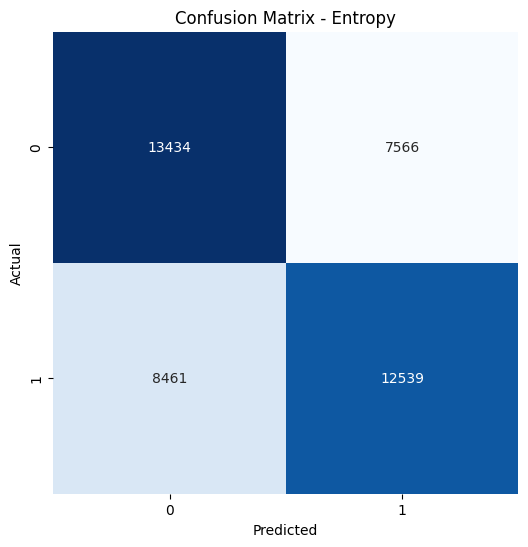

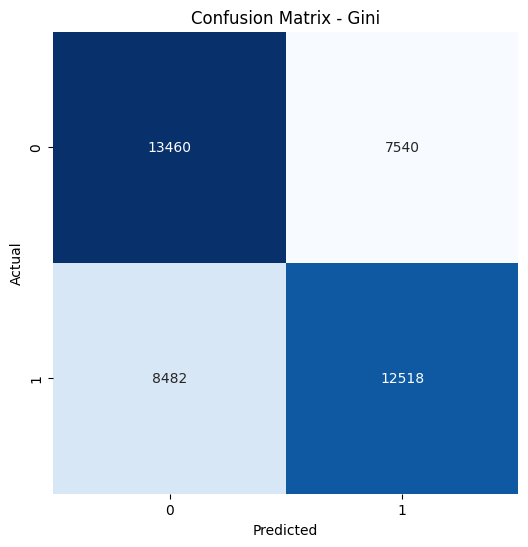

In [636]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(test_label, test_pred, title):
    cm = confusion_matrix(test_label, test_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Assuming clf and clf_gini are your RandomForestClassifier models trained previously

# Calculate predictions for entropy
y_pred_test = clf.predict(train_set)
plot_confusion_matrix(train_label, y_pred_test, 'Confusion Matrix - Entropy')

# Calculate predictions for gini
y_pred_test_gini = clf_gini.predict(train_set)
plot_confusion_matrix(train_label, y_pred_test_gini, 'Confusion Matrix - Gini')


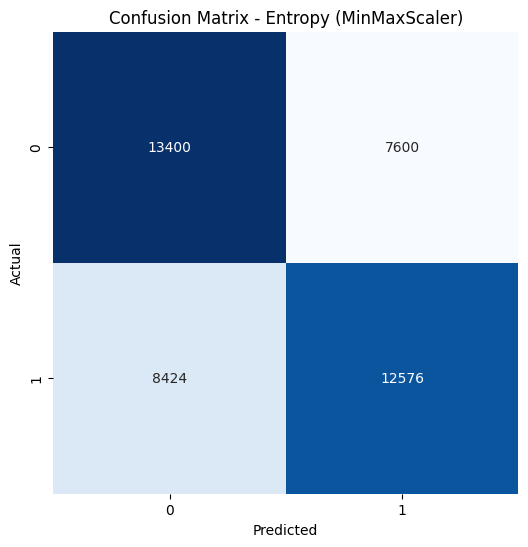

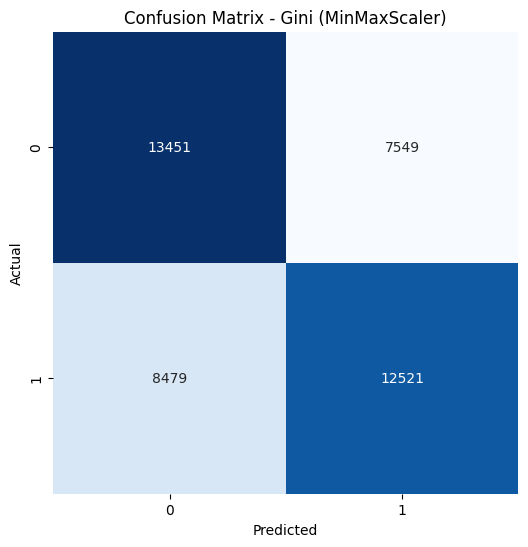

In [637]:

# Calculate predictions for entropy with MinMaxScaler
y_pred_test_minmax = clf_minmax.predict(train_set_minmax)
plot_confusion_matrix(train_label, y_pred_test_minmax, 'Confusion Matrix - Entropy (MinMaxScaler)')

# Calculate predictions for gini with MinMaxScaler
y_pred_test_gini_minmax = clf_gini_minmax.predict(train_set_minmax)
plot_confusion_matrix(train_label, y_pred_test_gini_minmax, 'Confusion Matrix - Gini (MinMaxScaler)')


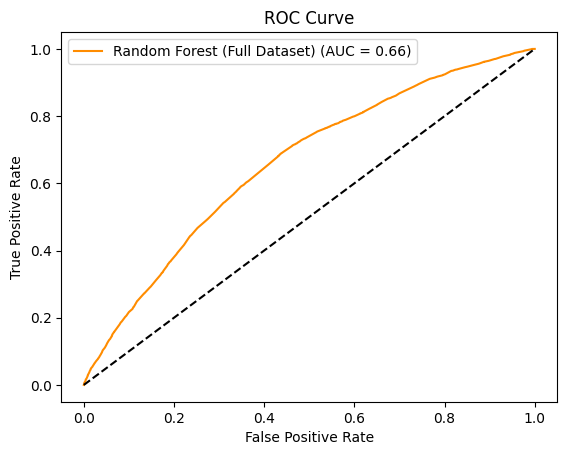

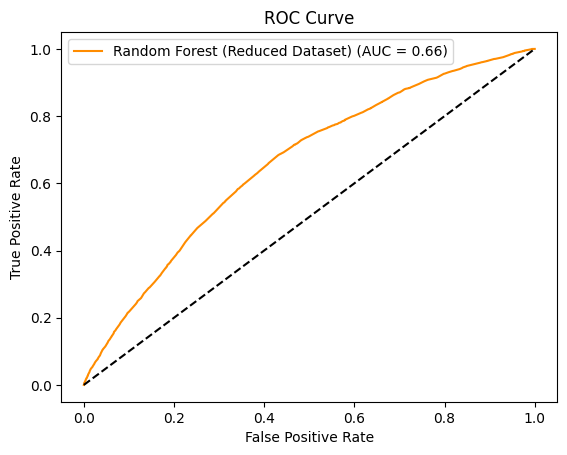

In [638]:
def plot_roc_curve(y_true, y_probs, label):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs)
    
    plt.plot(fpr, tpr, color='darkorange', label=f'{label} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# full df
y_probs_rf = clf.predict_proba(test_set)[:, 1]
plot_roc_curve(test_label, y_probs_rf, label='Random Forest (Full Dataset)')

# reduced df
y_probs_rf_gini = clf_gini.predict_proba(test_set)[:, 1]
plot_roc_curve(test_label, y_probs_rf_gini, label='Random Forest (Reduced Dataset)')

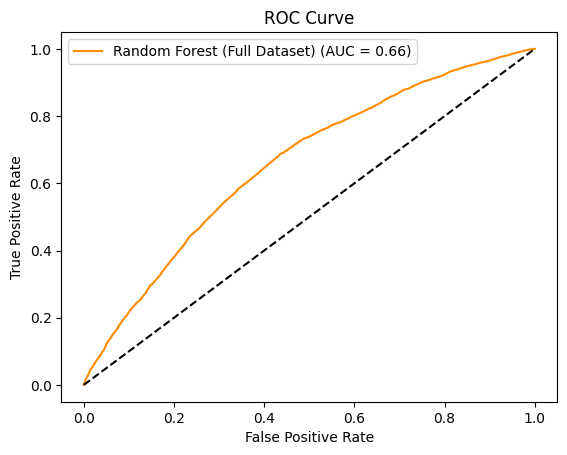

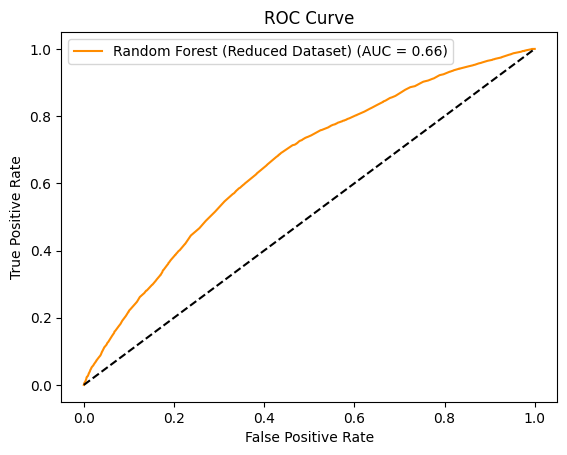

In [639]:

# full df
y_probs_rf_mm = clf_minmax.predict_proba(test_set_minmax)[:, 1]
plot_roc_curve(test_label, y_probs_rf_mm, label='Random Forest (Full Dataset)')

# reduced df
y_probs_rf_gini_mm = clf_gini_minmax.predict_proba(test_set_minmax)[:, 1]
plot_roc_curve(test_label, y_probs_rf_gini_mm, label='Random Forest (Reduced Dataset)')

# AdaBoost

In [640]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#With StandardScaler
ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.5, estimator=DecisionTreeClassifier(max_depth=1))
ada.fit(train_set, train_label)

# Predict labels for the test set
y_pred = ada.predict(test_set)

# Classification report
print("Classification Report:")
print(classification_report(test_label, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(test_label, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)



Classification Report:
              precision    recall  f1-score   support

       False       0.61      0.61      0.61      9000
        True       0.61      0.62      0.61      9000

    accuracy                           0.61     18000
   macro avg       0.61      0.61      0.61     18000
weighted avg       0.61      0.61      0.61     18000


Confusion Matrix:
[[5486 3514]
 [3446 5554]]


In [641]:
#With MinMaxScaler
ada_mm = AdaBoostClassifier(n_estimators=100, learning_rate=0.5, estimator=DecisionTreeClassifier(max_depth=1))
ada_mm.fit(train_set_minmax, train_label)

# Predict labels for the test set
y_pred_ada_mm = ada_mm.predict(test_set_minmax)

# Classification report
print("Classification Report:")
print(classification_report(test_label, y_pred_ada_mm))

# Confusion Matrix
conf_matrix_ada_mm = confusion_matrix(test_label, y_pred_ada_mm)
print("\nConfusion Matrix:")
print(conf_matrix_ada_mm)


Classification Report:
              precision    recall  f1-score   support

       False       0.61      0.61      0.61      9000
        True       0.61      0.62      0.61      9000

    accuracy                           0.61     18000
   macro avg       0.61      0.61      0.61     18000
weighted avg       0.61      0.61      0.61     18000


Confusion Matrix:
[[5486 3514]
 [3446 5554]]


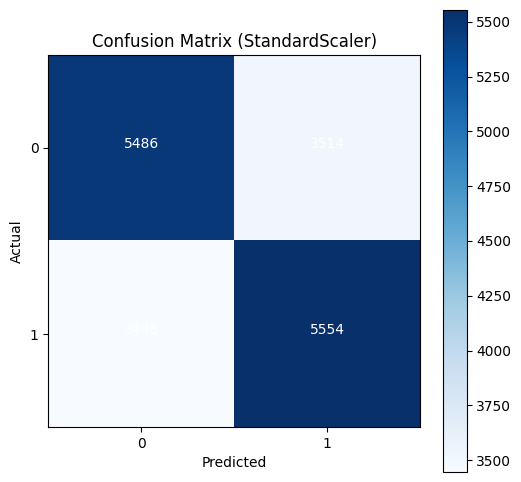

In [642]:

# Plotting Confusion Matrix
plt.figure(figsize=(6, 6))
plt.title('Confusion Matrix (StandardScaler)')
plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.show()


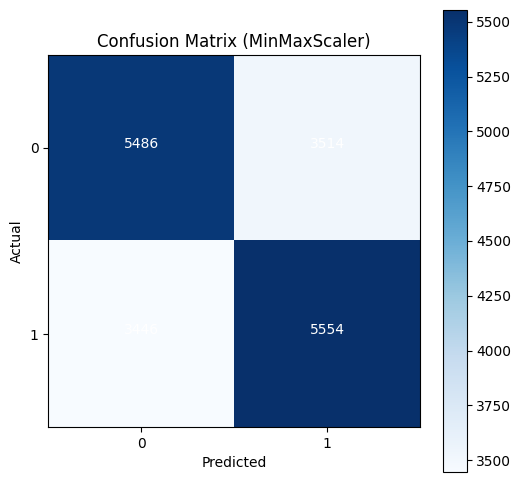

In [643]:

# Plotting Confusion Matrix
plt.figure(figsize=(6, 6))
plt.title('Confusion Matrix (MinMaxScaler)')
plt.imshow(conf_matrix_ada_mm, cmap=plt.cm.Blues, interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['0', '1'])
plt.yticks([0, 1], ['0', '1'])

for i in range(conf_matrix_ada_mm.shape[0]):
    for j in range(conf_matrix_ada_mm.shape[1]):
        plt.text(j, i, str(conf_matrix_ada_mm[i, j]), horizontalalignment='center', color='white' if conf_matrix_ada_mm[i, j] > conf_matrix_ada_mm.max() / 2 else 'black')

plt.show()


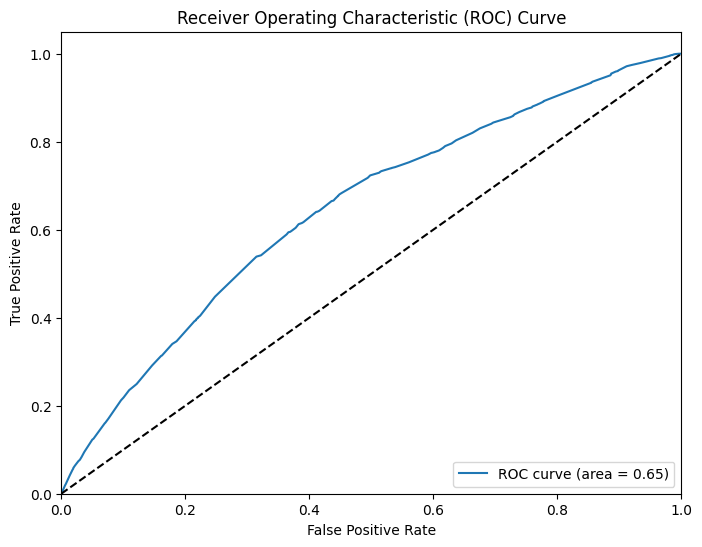

In [644]:

# ROC Curve and AUC
y_pred_proba_ada = ada.predict_proba(test_set)[:, 1]
fpr, tpr, thresholds = roc_curve(test_label, y_pred_proba_ada)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(test_label, y_pred_proba_ada))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

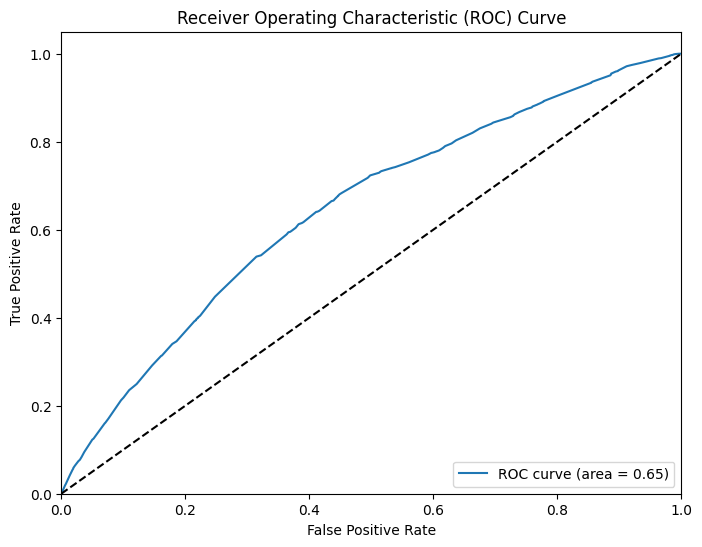

In [645]:

# ROC Curve and AUC - MInMaxScaler
y_pred_proba_ada_mm = ada_mm.predict_proba(test_set_minmax)[:, 1]
fpr_ada_mm, tpr_ada_mm, thresholds_ada_mm = roc_curve(test_label, y_pred_proba_ada_mm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_ada_mm, tpr_ada_mm, label='ROC curve (area = %0.2f)' % roc_auc_score(test_label, y_pred_proba_ada_mm))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Models comparison with AUC

ROC curves on StandardScaler dataset


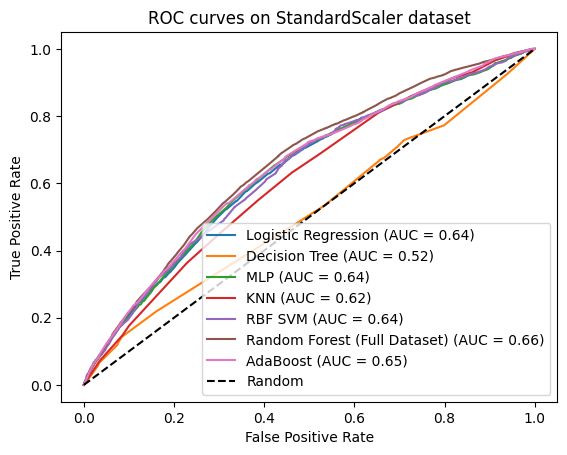

In [646]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

print("ROC curves on StandardScaler dataset")
# roc curves funcition
def plot_roc_curve(y_true, y_probs, label):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    auc_value = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_value:.2f})')

# calcolo e plotto le urve ROC per i vari modelli
# Regression
plot_roc_curve(test_label, probas_, 'Logistic Regression')

# Decision Tree
plot_roc_curve(test_label, test_pred_proba_dt, 'Decision Tree')

# MLP
plot_roc_curve(y_test, pred_prob, 'MLP')

# Knn
plot_roc_curve(test_label_small, y_scores, 'KNN')

# SVM : print only RBF cuz is better than 0.01

#plot_roc_curve(test_label_small, y_scores_linear, 'Linear SVM')
plot_roc_curve(test_label_small, y_scores_rbf, 'RBF SVM')

# Random Forest: print only full dataset cuz is better than reduced dataset

plot_roc_curve(test_label, y_probs_rf, 'Random Forest (Full Dataset)')
#plot_roc_curve(test_label_small, y_probs_rf_small, 'Random Forest (Reduced Dataset)')

#AdaBoost
plot_roc_curve(test_label, y_pred_proba_ada, 'AdaBoost')
# set
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves on StandardScaler dataset')
plt.legend(loc="lower right")
plt.show()


ROC curves on MinMaxScaler dataset


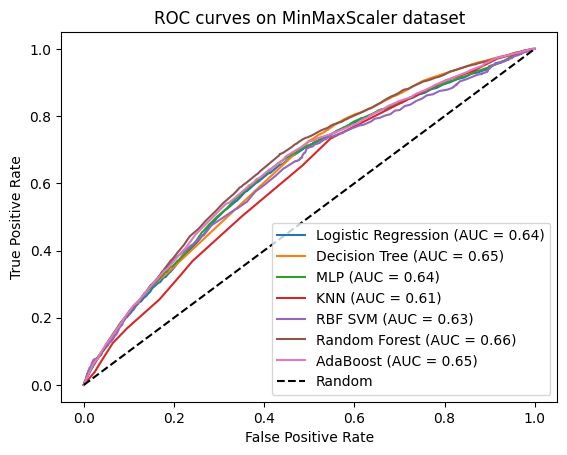

In [647]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

print("ROC curves on MinMaxScaler dataset")
# roc curves funcition
def plot_roc_curve(y_true, y_probs, label):
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    auc_value = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_value:.2f})')

# calcolo e plotto le urve ROC per i vari modelli
# Regression
plot_roc_curve(test_label, probas_minmax, 'Logistic Regression')

# Decision Tree
plot_roc_curve(test_label, test_pred_proba_dt_mm, 'Decision Tree')

# MLP
plot_roc_curve(y_test_mm, pred_prob_mm, 'MLP')

# Knn
plot_roc_curve(test_label_small, y_scores_mm, 'KNN')

# SVM : print only RBF cuz is better than 0.01

#plot_roc_curve(test_label_small, y_scores_linear, 'Linear SVM')
plot_roc_curve(test_label_small, y_scores_rbf_mm, 'RBF SVM')

# Random Forest: print only full dataset cuz is better than reduced dataset

plot_roc_curve(test_label, y_probs_rf_mm, 'Random Forest')
#plot_roc_curve(test_label_small, y_probs_rf_small, 'Random Forest (Reduced Dataset)')

# AdaBoost: print only full dataset cuz is better than reduced dataset
#adaboost_minmax
plot_roc_curve(test_label, y_pred_proba_ada_mm, 'AdaBoost')


# set
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves on MinMaxScaler dataset')
plt.legend(loc="lower right")
plt.show()
